In [385]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import os

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest



In [685]:

class ForecastLSTM:
    def __int__(self, random_speed: int = 1234):
        self.random_speed = random_speed

    

In [5]:
# /Users/wani/Desktop/
file_path = './datasets/'

In [34]:
dissoultion = pd.read_csv(file_path + 'dissolution_tank.csv', encoding='cp949')
dissoultion


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [27]:
# 이상치 탐지 ...
def outlier_iqr(data, column): 
    # lower, upper     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 1사 4사 분위에 속하는 데이터 조건에 저장
    condition1 = data[column] > upper
    condition2 = data[column] < lower
    a1 = data[condition1].index
    a2 = data[condition2].index
    data.drop(a1, inplace = True)
    data.drop(a2, inplace = True)
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다, 제거 완료')

    #print(len(data2))

In [ ]:
dissoultion

In [25]:
len(dissoultion[dissoultion['INSP'] > 3.22]) # 3.23 = 371
len(dissoultion[dissoultion['INSP'] == 3.22]) # 3.22 = 101019
len(dissoultion[dissoultion['INSP'] == 3.21]) # 3.21 = 65608
len(dissoultion[dissoultion['INSP'] == 3.20]) # 3.20 = 77772
len(dissoultion[dissoultion['INSP'] == 3.19]) # 3.19 482383

len(dissoultion[dissoultion['INSP'] == 3.18]) # 3.18 = 107858
len(dissoultion[dissoultion['INSP'] == 3.17]) # 3.17 = 189

# EDA애서 놓치고 있었던 사항은 INSP 분포가 

189

In [30]:
INSPE = pd.DataFrame({'범위':['3.17', '3.18', '3.19', '3.20', '3.21', '3.22', '3.23'],
                             '데이터수':[189, 107858, 482383, 77772, 65608, 101019, 371]})
INSPE # 3.17 ~ 3.23 사이의 데이터의 수 분포 많이 분포하고 있음 /상관 관계 파악

,범위,데이터수
0,3.17,189
1,3.18,107858
2,3.19,482383
3,3.20,77772
4,3.21,65608
5,3.22,101019
6,3.23,371


In [ ]:
corr(method='pearson')


In [24]:

dissoultion[dissoultion['INSP'] < 3.18] 


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
6856,2020-03-04 11:25,6856,367,205,458,3.17,OK
10036,2020-03-04 16:43,10036,382,230,613,3.17,OK
15376,2020-03-05 1:37,15376,386,230,513,3.17,OK
23796,2020-03-05 15:39,23796,400,220,167,3.17,OK
24063,2020-03-05 16:06,24063,413,223,618,3.17,OK
...,...,...,...,...,...,...,...
810843,2020-04-29 7:24,810843,384,172,407,3.17,OK
810936,2020-04-29 7:33,810936,391,223,245,3.17,OK
815236,2020-04-29 14:43,815236,415,214,348,3.17,OK
833226,2020-04-30 20:42,833226,394,195,735,3.17,OK


In [26]:
dissoultion[dissoultion['INSP'] > 3.22] 


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
1535,2020-03-04 2:33,1535,735,1711,578,3.23,OK
7564,2020-03-04 12:36,7564,740,1744,140,3.23,OK
9525,2020-03-04 15:52,9525,748,1777,498,3.23,OK
11584,2020-03-04 19:18,11584,754,1729,114,3.23,OK
14115,2020-03-04 23:31,14115,720,1731,567,3.23,OK
...,...,...,...,...,...,...,...
828095,2020-04-30 12:09,828095,722,1746,686,3.23,OK
829534,2020-04-30 14:33,829534,777,1744,26,3.23,OK
831764,2020-04-30 18:16,831764,749,1730,483,3.23,OK
832555,2020-04-30 19:35,832555,776,1730,120,3.23,OK


In [32]:
dissoultion.corr(method='pearson') # INSP 값이 높을수록 MOTORSPEED가 높음 / TEMP도 INSP가 높으면

#이전에는 outliers로 이상 데이터를 제거하였는데, 문제는 INSP에 있음 -> 이상 데이터 행을 제거하면 INSP 모두 3.19로 일정한 값을 가짐 
# 왜그럴까 생각을 해서 이상 데이터 중 INSP 열만 제외하고 설정하여 제거후 표준화 시키자..


,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
NUM,1.000000,0.000188,-0.000050,0.080079,-0.000524
MELT_TEMP,0.000188,1.000000,0.944929,-0.000336,0.916295
MOTORSPEED,-0.000050,0.944929,1.000000,0.000123,0.887813
MELT_WEIGHT,0.080079,-0.000336,0.000123,1.000000,-0.000005
INSP,-0.000524,0.916295,0.887813,-0.000005,1.000000


In [35]:
dissoultion_c = dissoultion.copy()

In [36]:
#MELT_TEMP
print('=======MELT_TEMP=======')
outlier_iqr(dissoultion,'MELT_TEMP')


#MELT_TEMP
print('=======MOTORSPEED=======')
outlier_iqr(dissoultion,'MOTORSPEED')

#MELT_WEIGHT
print('=======MELT_WEIGHT=======')
outlier_iqr(dissoultion,'MELT_WEIGHT')



=======MELT_TEMP=======
IQR은 72.0 이다.
lower bound 값은 322.0 이다.
upper bound 값은 610.0 이다.
총 이상치 개수는 167059 이다, 제거 완료
=======MOTORSPEED=======
IQR은 89.0 이다.
lower bound 값은 -34.5 이다.
upper bound 값은 321.5 이다.
총 이상치 개수는 0 이다, 제거 완료
=======MELT_WEIGHT=======
IQR은 396.0 이다.
lower bound 값은 -408.0 이다.
upper bound 값은 1176.0 이다.
총 이상치 개수는 36544 이다, 제거 완료


In [687]:
dissoul

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,0
1,2020-03-04 0:00,1,433,78,609,3.19,0
2,2020-03-04 0:00,2,464,154,608,3.19,0
3,2020-03-04 0:00,3,379,212,606,3.19,0
4,2020-03-04 0:00,4,798,1736,604,3.21,0
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,0
835196,2020-04-30 23:59,835196,385,206,317,3.19,0
835197,2020-04-30 23:59,835197,465,148,316,3.20,0
835198,2020-04-30 23:59,835198,467,0,314,3.19,0


In [37]:
dissoultion # 이상 데이터 제거 / 나머지 INSP 확인해볼까유?


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
6,2020-03-04 0:00,6,390,212,602,3.19,OK
...,...,...,...,...,...,...,...
835193,2020-04-30 23:59,835193,391,213,320,3.18,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [41]:
dissoultion[dissoultion['INSP'] >= 3.22] # 이렇게 하니까 3.22이상의 값들은 모두 제거됨


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG


In [43]:
dissoultion[dissoultion['INSP'] < 3.18] # 다만 3.18 아래의 값들은 이상 없음 /


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
6856,2020-03-04 11:25,6856,367,205,458,3.17,OK
10036,2020-03-04 16:43,10036,382,230,613,3.17,OK
15376,2020-03-05 1:37,15376,386,230,513,3.17,OK
23796,2020-03-05 15:39,23796,400,220,167,3.17,OK
24063,2020-03-05 16:06,24063,413,223,618,3.17,OK
...,...,...,...,...,...,...,...
810843,2020-04-29 7:24,810843,384,172,407,3.17,OK
810936,2020-04-29 7:33,810936,391,223,245,3.17,OK
815236,2020-04-29 14:43,815236,415,214,348,3.17,OK
833226,2020-04-30 20:42,833226,394,195,735,3.17,OK


In [46]:
d = dissoultion[dissoultion['TAG'].str.contains('NG')]

In [49]:
d[d['INSP'] > 3.21]

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG


In [45]:
dissoultion[dissoultion['TAG'].str.contains('OK')]

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
6,2020-03-04 0:00,6,390,212,602,3.19,OK
...,...,...,...,...,...,...,...
835193,2020-04-30 23:59,835193,391,213,320,3.18,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [52]:
dissoultion_c[dissoultion_c['TAG'].str.contains('OK')]

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [54]:
dissoul = dissoultion_c.copy()

In [56]:
#replace(24, 100)
dissoul = dissoul.replace('OK', 0) # 정상 OK 0, 불량 NG 1 //
dissoul = dissoul.replace('NG', 1)
dissoul

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,0
1,2020-03-04 0:00,1,433,78,609,3.19,0
2,2020-03-04 0:00,2,464,154,608,3.19,0
3,2020-03-04 0:00,3,379,212,606,3.19,0
4,2020-03-04 0:00,4,798,1736,604,3.21,0
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,0
835196,2020-04-30 23:59,835196,385,206,317,3.19,0
835197,2020-04-30 23:59,835197,465,148,316,3.20,0
835198,2020-04-30 23:59,835198,467,0,314,3.19,0


In [67]:
# 독립변수
dissoul_x = dissoul[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT',
                         'INSP']]
dissoul_y = dissoul[['TAG']]


In [83]:
dissoul_x

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
0,489,116,631,3.19
1,433,78,609,3.19
2,464,154,608,3.19
3,379,212,606,3.19
4,798,1736,604,3.21
...,...,...,...,...
835195,755,1743,318,3.21
835196,385,206,317,3.19
835197,465,148,316,3.20
835198,467,0,314,3.19


In [87]:
# Minmax scaling / 우리는 모델을 오직 정상
dissoul_x['MELT_TEMP'] = MinMaxScaler().fit_transform(dissoul_x['MELT_TEMP'].values.reshape(-1, 1))
dissoul_x['MOTORSPEED'] =  MinMaxScaler().fit_transform(dissoul_x['MOTORSPEED'].values.reshape(-1, 1))
dissoul_x['MELT_WEIGHT'] =  MinMaxScaler().fit_transform(dissoul_x['MELT_WEIGHT'].values.reshape(-1, 1))
dissoul_x['INSP'] =  MinMaxScaler().fit_transform(dissoul_x['INSP'].values.reshape(-1, 1))
dissoul_x

/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_43624/49536758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dissoul_x['MELT_TEMP'] = MinMaxScaler().fit_transform(dissoul_x['MELT_TEMP'].values.reshape(-1, 1))
/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_43624/49536758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dissoul_x['MOTORSPEED'] =  MinMaxScaler().fit_transform(dissoul_x['MOTORSPEED'].values.reshape(-1, 1))
/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykerne

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
0,0.345420,0.064302,0.011420,0.333333
1,0.238550,0.043237,0.011022,0.333333
2,0.297710,0.085366,0.011004,0.333333
3,0.135496,0.117517,0.010968,0.333333
4,0.935115,0.962306,0.010932,0.666667
...,...,...,...,...
835195,0.853053,0.966186,0.005755,0.666667
835196,0.146947,0.114191,0.005737,0.333333
835197,0.299618,0.082040,0.005719,0.500000
835198,0.303435,0.000000,0.005683,0.333333


In [372]:
x_train, x_test, y_train, y_test = train_test_split(dissoul_x, dissoul_y, stratify=y, 
                                                    test_size=0.3, random_state=42)

In [91]:
print(x_train.shape, x_test.shape)

(584640, 4) (250560, 4)


In [92]:
np.unique(y_train, return_counts=True) # 0 정상 / 1 이상 


(array([0, 1]), array([460693, 123947]))

In [109]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time 


In [97]:
model = sm.Logit(y_train, x_train)
results = model.fit(method = "newton")


Optimization terminated successfully.
         Current function value: 0.441426
         Iterations 9


In [98]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    TAG   No. Observations:               584640
Model:                          Logit   Df Residuals:                   584636
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Oct 2022   Pseudo R-squ.:                  0.1455
Time:                        22:05:13   Log-Likelihood:            -2.5808e+05
converged:                       True   LL-Null:                   -3.0203e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MELT_TEMP      -5.8338      0.047   -124.996      0.000      -5.925      -5.742
MOTORSPEED     -4.4100      0.070    -63.281      0.000      -4.547      -4.273
MELT_WEIGHT     2.8743      0.143     20.157      0.000       2.595       3.154
INSP            2.2951      0.039     59.437      0.000       2.219       2.371
===============================================================================
"""

In [99]:
results.params # 회귀계수


MELT_TEMP     -5.833795
MOTORSPEED    -4.409977
MELT_WEIGHT    2.874320
INSP           2.295119
dtype: float64

In [100]:
np.exp(results.params)# 온도 1도 높을수록 0.0029배, 모터 속도가 1 높을수록 0.012배, 무게가 1 높을수록 17.7배  INSP 1높을 수록


MELT_TEMP       0.002927
MOTORSPEED      0.012155
MELT_WEIGHT    17.713369
INSP            9.925617
dtype: float64

In [101]:
pred_y = results.predict(x_test)
pred_y #   1이될 확률을 나타내는 결과 / 즉 NG가 될 확률을 의미함.


284331    0.356519
759167    0.197581
383871    0.222034
593721    0.316223
163438    0.232899
            ...   
763412    0.250084
366119    0.118016
582486    0.254191
49628     0.375295
59717     0.140789
Length: 250560, dtype: float64

In [192]:
def cut_off(y, threshold) :
    Y = y.copy()  # 불량품을 측정할 때 보통 0.5보다 크게 잡는다. 
    Y[Y>threshold] = 1
    Y[Y<threshold] = 0
    return Y.astype(int)
    
pred_Y = cut_off(pred_y, 0.7)
pred_Y

284331    0
759167    0
383871    0
593721    0
163438    0
         ..
763412    0
366119    0
582486    0
49628     0
59717     0
Length: 250560, dtype: int64

In [193]:

cfmat = confusion_matrix(y_test, pred_Y)
print(cfmat)

[[197439      1]
 [ 53119      1]]


In [194]:
pred_Y

284331    0
759167    0
383871    0
593721    0
163438    0
         ..
763412    0
366119    0
582486    0
49628     0
59717     0
Length: 250560, dtype: int64

In [195]:
y_test

,TAG
284331,1
759167,0
383871,1
593721,1
163438,0
...,...
763412,0
366119,1
582486,0
49628,0


In [196]:
def acc(cfmat):
    return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat) 

# acc 0.787...

0.7879948914431673

In [198]:
threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
    pred_Y = cut_off(pred_y,i)
    cfmat = confusion_matrix(y_test, pred_Y)
    table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.212005
0.1,0.412113
0.2,0.595394
0.3,0.739216
0.4,0.781629
0.5,0.787803
0.6,0.787979
0.7,0.787995
0.8,0.787991


AUC: 0.7483778263028055


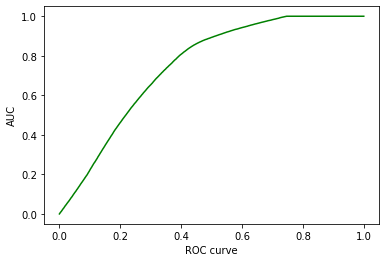

In [206]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(y_test,pred_y, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr, 'g-', label='AUC')
plt.xlabel('ROC curve')
plt.ylabel('AUC')
# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [380]:
# 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

clf = RandomForestClassifier(n_estimators=20, max_depth=5,random_state=0)
clf.fit(x_train, y_train)

predict1 = clf.predict(x_test)
print(accuracy_score(y_test, predict1))

/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_43624/988712061.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


0.7906409642401022


In [382]:

clf = RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0)
clf.fit(x_train, y_train)

predict2 = clf.predict(x_test)
print(accuracy_score(y_test, predict2)) #샘플 데이터의 수를 증가하였음 / 그것보다 깊이를 증가...

/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_43624/2575622671.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


0.7944843550446998


In [383]:
# 트리 깊이를 증가시켜서 학습 시키면 더 높은 결과를 예측될 것인가?
#
clf = RandomForestClassifier(n_estimators=1000, max_depth=20,random_state=0)
clf.fit(x_train, y_train)

predict2 = clf.predict(x_test)
print(accuracy_score(y_test, predict2)) #샘플 데이터의 수를 증가하였음 / 그것보다 깊이를 증가... 
# test 결과 적당하 ㄴ체크 샘플 데이터개수 /

/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_43624/1138915946.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


0.7905252234993614


In [ ]:
# Minmax scaling / 우리는 모델을 오직 정상
dis['MELT_TEMP'] = MinMaxScaler().fit_transform(dis['MELT_TEMP'].values.reshape(-1, 1))
dis['MOTORSPEED'] =  MinMaxScaler().fit_transform(dis['MOTORSPEED'].values.reshape(-1, 1))
dis['MELT_WEIGHT'] =  MinMaxScaler().fit_transform(dis['MELT_WEIGHT'].values.reshape(-1, 1))
dis['INSP'] =  MinMaxScaler().fit_transform(diss['INSP'].values.reshape(-1, 1))
dis

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
0,0.345420,0.064302,0.011420,0.333333
1,0.238550,0.043237,0.011022,0.333333
2,0.297710,0.085366,0.011004,0.333333
3,0.135496,0.117517,0.010968,0.333333
4,0.935115,0.962306,0.010932,0.666667
...,...,...,...,...
835195,0.853053,0.966186,0.005755,0.666667
835196,0.146947,0.114191,0.005737,0.333333
835197,0.299618,0.082040,0.005719,0.500000
835198,0.303435,0.000000,0.005683,0.333333


In [277]:
X_train, X_test = train_test_split(dis, test_size=0.3, random_state=74)
X_train = X_train[dis.TAG == 0]
X_train = X_train.drop(['STD_DT'], axis = 1)
X_train = X_train.drop(['NUM'], axis = 1)
X_train = X_train.drop(['TAG'], axis=1)

y_test = X_test['TAG']
X_test = X_test.drop(['TAG'], axis=1)
X_test = X_test.drop(['STD_DT'], axis = 1)
X_test = X_test.drop(['NUM'], axis = 1)


X_train = X_train.values
X_test = X_test.values

X_train.shape

# X_train

/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_43624/3029498933.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[dis.TAG == 0]


(460561, 4)

In [278]:
X_train


array([[0.38740458, 0.077051  , 0.00269673, 0.33333333],
       [0.22137405, 0.09478936, 0.01214436, 0.33333333],
       [0.17938931, 0.11529933, 0.01207196, 0.16666667],
       ...,
       [0.14503817, 0.12472284, 0.01199957, 0.33333333],
       [0.10687023, 0.1191796 , 0.0146963 , 0.16666667],
       [0.32061069, 0.09700665, 0.00182799, 0.33333333]])

In [223]:
X_train.astype(float)
X_test.astype(float) # 오류 생김 

array([[3.95038168e-01, 1.01441242e-01, 3.43878955e-03, 3.33333333e-01],
       [2.67175573e-01, 5.15521064e-02, 5.64685441e-03, 3.33333333e-01],
       [3.05343511e-01, 7.53880266e-02, 1.52030696e-03, 3.33333333e-01],
       ...,
       [3.53053435e-01, 6.87361419e-02, 9.39332513e-03, 3.33333333e-01],
       [8.24427481e-01, 9.67849224e-01, 2.71483385e-04, 8.33333333e-01],
       [3.12977099e-01, 6.70731707e-02, 4.90479983e-03, 3.33333333e-01]])

In [254]:
input_dim = X_train.shape[1]
print(input_dim)

4


In [255]:

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [256]:
# 00 에폭(epoch) 동안 16의 배치 사이즈(batch size
nb_epoch = 20
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h8", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)



2022-10-31 23:30:35.904282: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 23:30:35.904323: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 23:30:35.904920: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [257]:
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size,
                    shuffle=True, validation_data=(X_test, X_test), verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history # MinMax scale // error -> list type floating


Epoch 1/20
   85/14393 [..............................] - ETA: 29s - loss: 0.1356 - accuracy: 0.2176 

2022-10-31 23:30:45.598711: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 23:30:45.598731: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 23:30:45.638606: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 23:30:45.639971: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 23:30:45.640999: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_23_30_45

2022-10-31 23:30:45.642365: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_10_31_23_30_45/waniui-MacBook-Pro.local.trace.json.gz
2022-10-31 23:30:45.645469: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_23_30_45

2022-10-31 

14393/14393 [==============================] - 13s 900us/step - loss: 0.0013 - accuracy: 0.9773 - val_loss: 3.4290e-05 - val_accuracy: 0.9986
INFO:tensorflow:Assets written to: model.h8/assets
Epoch 2/20
14393/14393 [==============================] - 13s 904us/step - loss: 2.5342e-05 - accuracy: 0.9979 - val_loss: 1.7489e-05 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: model.h8/assets
Epoch 3/20
14393/14393 [==============================] - 14s 965us/step - loss: 1.6864e-05 - accuracy: 0.9983 - val_loss: 1.4915e-05 - val_accuracy: 0.9975
INFO:tensorflow:Assets written to: model.h8/assets
Epoch 4/20
14393/14393 [==============================] - 13s 930us/step - loss: 1.2864e-05 - accuracy: 0.9976 - val_loss: 1.2491e-05 - val_accuracy: 0.9993
INFO:tensorflow:Assets written to: model.h8/assets
Epoch 5/20
14393/14393 [==============================] - 13s 930us/step - loss: 1.0584e-05 - accuracy: 0.9975 - val_loss: 8.1388e-06 - val_accuracy: 0.9999
INFO:tensorflow:Assets wri

In [258]:
# 이상 탐지 모델 -> anomaly detection
# test 사이즈를 크게 해야하는 이유는 본래 original 데이터가 확실히 이상 탐지 모델은 OK = TAG 0인 정상인 데이터를 학습시켜야 하기 떄문에 
# 현재 데이터 특성 상 좀 더 random하게 추출 해야 함을 고려함....

# 오히려 outliers 작업을 하고 난 후보다 휠씬 정확도가 좋아짐 ... #겨 결국 over fiitting이 진행됨을 알 수 있음 ..

# epoch 늘리면 오히려 잘못된 학습할 가능성이 큼 

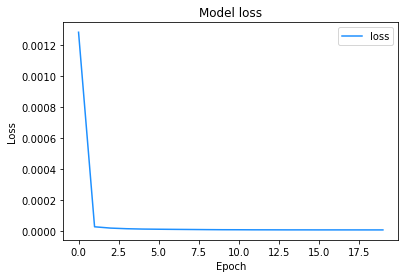

In [259]:
plt.plot(history['loss'], 'dodgerblue', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


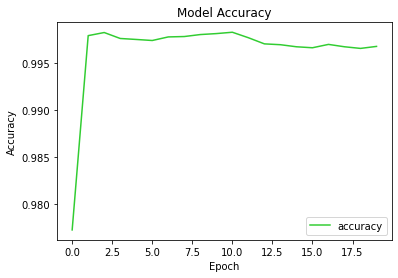

In [260]:
# 모델 정확도 시각화
plt.plot(history['accuracy'], 'limegreen', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [261]:
predictions = autoencoder.predict(X_test)
predictions

array([[0.395212  , 0.10148003, 0.00349344, 0.3340478 ],
       [0.2668795 , 0.05084001, 0.00564275, 0.3335419 ],
       [0.30528447, 0.07500979, 0.00148176, 0.33382493],
       ...,
       [0.12124974, 0.12446377, 0.01275416, 0.3333719 ],
       [0.2764891 , 0.05532616, 0.01214249, 0.50074416],
       [0.2974126 , 0.04693587, 0.00932282, 0.33352217]], dtype=float32)

In [262]:
#predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'TAG': y_test})
error_df

,reconstruction_error,TAG
71777,1.362904e-07,0
138911,1.595661e-07,0
170589,9.742702e-08,0
118217,2.896385e-07,0
422452,1.055183e-07,0
...,...,...
682614,9.730066e-06,0
115241,3.211959e-07,0
14646,3.628003e-07,0
757121,2.609303e-07,0


In [264]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

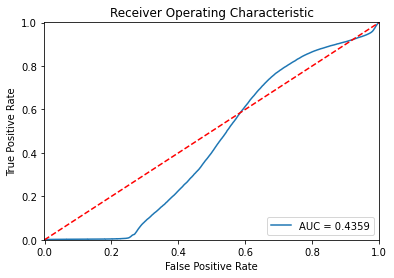

In [266]:
fpr, tpr, thresholds = roc_curve(error_df.TAG, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [268]:

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [269]:
# 에폭(epoch) 동안 32의 배치 사이즈(batch size
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h9", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)



2022-10-31 23:37:37.909117: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 23:37:37.909141: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 23:37:37.909479: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [270]:
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size,
                    shuffle=True, validation_data=(X_test, X_test), verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history # MinMax scale // error -> list type floating


Epoch 1/10
   68/14393 [..............................] - ETA: 39s - loss: 0.0652 - accuracy: 0.1926     

2022-10-31 23:38:01.006322: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 23:38:01.006342: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 23:38:01.062195: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 23:38:01.063210: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 23:38:01.064496: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_23_38_01

2022-10-31 23:38:01.065651: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_10_31_23_38_01/waniui-MacBook-Pro.local.trace.json.gz
2022-10-31 23:38:01.069064: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_23_38_01

2022-10-31 

14393/14393 [==============================] - 14s 928us/step - loss: 5.3071e-04 - accuracy: 0.9851 - val_loss: 2.5954e-05 - val_accuracy: 0.9998
INFO:tensorflow:Assets written to: model.h9/assets
Epoch 2/10
14393/14393 [==============================] - 12s 868us/step - loss: 2.1970e-05 - accuracy: 0.9994 - val_loss: 1.5298e-05 - val_accuracy: 0.9999
INFO:tensorflow:Assets written to: model.h9/assets
Epoch 3/10
14393/14393 [==============================] - 12s 866us/step - loss: 1.3926e-05 - accuracy: 0.9984 - val_loss: 1.0203e-05 - val_accuracy: 0.9978
INFO:tensorflow:Assets written to: model.h9/assets
Epoch 4/10
14393/14393 [==============================] - 13s 871us/step - loss: 9.8182e-06 - accuracy: 0.9984 - val_loss: 7.3993e-06 - val_accuracy: 0.9996
INFO:tensorflow:Assets written to: model.h9/assets
Epoch 5/10
14393/14393 [==============================] - 13s 873us/step - loss: 8.6952e-06 - accuracy: 0.9989 - val_loss: 6.5461e-06 - val_accuracy: 0.9999
INFO:tensorflow:Assets

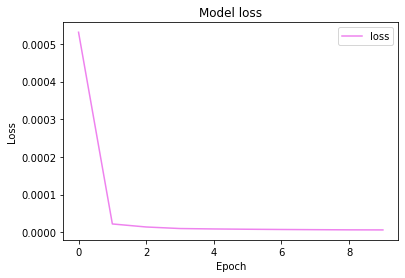

In [272]:
plt.plot(history['loss'], 'violet', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

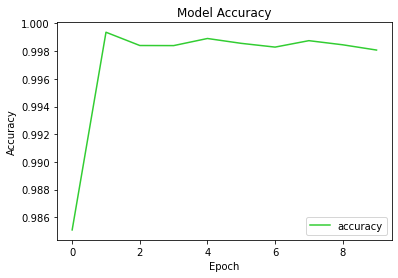

In [273]:
# 모델 정확도 시각화
plt.plot(history['accuracy'], 'limegreen', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [275]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'TAG': y_test})
error_df

,reconstruction_error,TAG
71777,1.541215e-07,0
138911,9.685481e-08,0
170589,1.148585e-07,0
118217,9.651715e-08,0
422452,1.427952e-07,0
...,...,...
682614,2.299727e-07,0
115241,8.637054e-08,0
14646,7.666299e-08,0
757121,5.551041e-08,0


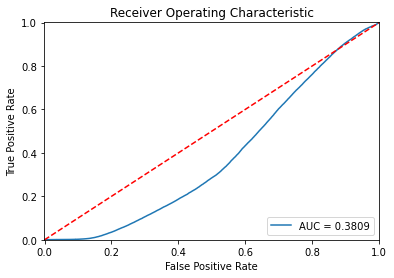

In [276]:
fpr, tpr, thresholds = roc_curve(error_df.TAG, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [279]:

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [280]:
# 00 에폭(epoch) 동안 16의 배치 사이즈(batch size
nb_epoch = 10
batch_size = 16
autoencoder.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h10", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


2022-10-31 23:44:34.962701: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 23:44:34.962718: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 23:44:34.962785: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [281]:
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size,
                    shuffle=True, validation_data=(X_test, X_test), verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history # MinMax scale // error -> list type floating

Epoch 1/10
  182/28786 [..............................] - ETA: 32s - loss: 0.0700 - accuracy: 0.4615    

2022-10-31 23:44:47.646572: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 23:44:47.646589: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 23:44:47.677321: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 23:44:47.678143: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 23:44:47.679042: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_23_44_47

2022-10-31 23:44:47.680279: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_10_31_23_44_47/waniui-MacBook-Pro.local.trace.json.gz
2022-10-31 23:44:47.684104: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_23_44_47

2022-10-31 

28786/28786 [==============================] - 26s 881us/step - loss: 8.2919e-04 - accuracy: 0.9748 - val_loss: 1.7846e-04 - val_accuracy: 0.9974
INFO:tensorflow:Assets written to: model.h10/assets
Epoch 2/10
28786/28786 [==============================] - 26s 891us/step - loss: 1.6456e-04 - accuracy: 0.9981 - val_loss: 1.6324e-04 - val_accuracy: 0.9975
INFO:tensorflow:Assets written to: model.h10/assets
Epoch 3/10
28786/28786 [==============================] - 26s 892us/step - loss: 1.6029e-04 - accuracy: 0.9988 - val_loss: 1.5849e-04 - val_accuracy: 0.9997
INFO:tensorflow:Assets written to: model.h10/assets
Epoch 4/10
28786/28786 [==============================] - 26s 912us/step - loss: 1.5891e-04 - accuracy: 0.9992 - val_loss: 1.6136e-04 - val_accuracy: 0.9997
Epoch 5/10
28786/28786 [==============================] - 25s 865us/step - loss: 1.5872e-04 - accuracy: 0.9993 - val_loss: 1.6658e-04 - val_accuracy: 0.9996
Epoch 6/10
28786/28786 [==============================] - 27s 948us/st

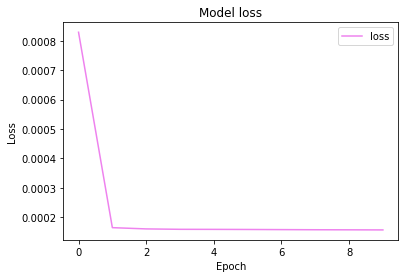

In [282]:
# 확실히 배치사이즈 16으로 줄이고, epoch 10으로 줄이는게 답인듯 

plt.plot(history['loss'], 'violet', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

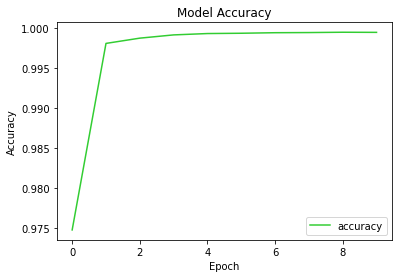

In [283]:
# 모델 정확도 시각화 정확도가 안정적으로 바뀜
plt.plot(history['accuracy'], 'limegreen', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [284]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'TAG': y_test})
error_df

,reconstruction_error,TAG
71777,0.000010,0
138911,0.000011,0
170589,0.000005,0
118217,0.000125,0
422452,0.000042,0
...,...,...
682614,0.000022,0
115241,0.000055,0
14646,0.000044,0
757121,0.000041,0


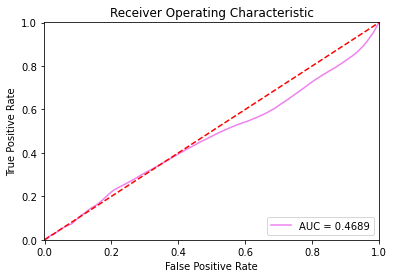

In [288]:
fpr, tpr, thresholds = roc_curve(error_df.TAG, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'violet', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show(); # 결론 이상탐지 모델 

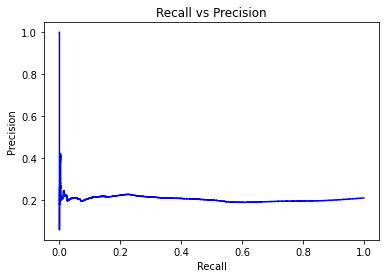

In [289]:
precision, recall, th = precision_recall_curve(error_df.TAG, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

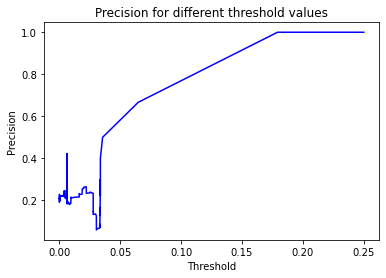

In [290]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

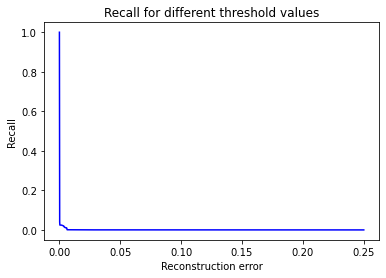

In [291]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

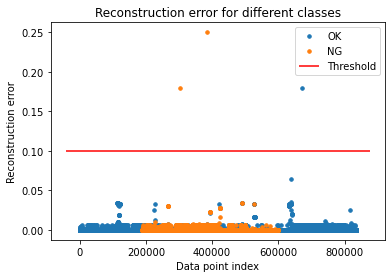

In [299]:
threshold = 0.1


groups = error_df.groupby('TAG')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "NG" if name == 1 else "OK")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [303]:
y_train.values


array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [405]:

import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim


In [425]:
OK_dis = dis[dis['TAG'] == 0]
NG_dis = dis[dis['TAG'] == 1]


In [429]:
NG_dis

# OK 0, NG 1으로 데이터를 일단 분할? -> 
#pd.concat([x_train, y_train], axis=1)

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
188733,2020-03-17 2:33,188733,0.057252,0.111973,0.003710,0.166667,1
188823,2020-03-17 2:42,188823,0.106870,0.111419,0.001195,0.166667,1
188826,2020-03-17 2:42,188826,0.103053,0.112528,0.001104,0.333333,1
188896,2020-03-17 2:49,188896,0.118321,0.114191,0.002027,0.166667,1
188903,2020-03-17 2:50,188903,0.108779,0.131929,0.002733,0.333333,1
...,...,...,...,...,...,...,...
598507,2020-04-14 13:30,598507,0.278626,0.098670,0.006226,0.333333,1
598551,2020-04-14 13:35,598551,0.286260,0.040466,0.004869,0.333333,1
598567,2020-04-14 13:36,598567,0.274809,0.086475,0.004271,0.333333,1
598597,2020-04-14 13:39,598597,0.280534,0.088692,0.003204,0.333333,1


In [691]:
NG_dis[NG_dis['STD_DT'].str.contains('2020-03-17')]

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
188733,2020-03-17 2:33,188733,0.057252,0.111973,0.003710,0.166667,1
188823,2020-03-17 2:42,188823,0.106870,0.111419,0.001195,0.166667,1
188826,2020-03-17 2:42,188826,0.103053,0.112528,0.001104,0.333333,1
188896,2020-03-17 2:49,188896,0.118321,0.114191,0.002027,0.166667,1
188903,2020-03-17 2:50,188903,0.108779,0.131929,0.002733,0.333333,1
...,...,...,...,...,...,...,...
201576,2020-03-17 23:57,201576,0.103053,0.111973,0.007801,0.333333,1
201583,2020-03-17 23:58,201583,0.103053,0.112528,0.007602,0.333333,1
201586,2020-03-17 23:58,201586,0.187023,0.111419,0.007511,0.166667,1
201593,2020-03-17 23:59,201593,0.106870,0.112528,0.007330,0.166667,1


In [657]:
# 
#dx_MnX = dissoul_MnX[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT']]
#dy_Mnx = dissoul_MnX[['TAG']]
NG_dis_x = NG_dis[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']]
OK_dis_x = OK_dis[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']]
#NG_dis[['TAG']]

In [703]:
#np.array(NG_dis_x).reshape(5, 177067)


array([[0.05725191, 0.11197339, 0.00371027, ..., 1.        , 0.15839695,
        0.11585366],
       [0.00365598, 0.16666667, 1.        , ..., 0.09534368, 0.00608123,
        0.33333333],
       [1.        , 0.28816794, 0.04600887, ..., 0.33333333, 1.        ,
        0.1851145 ],
       [0.12583149, 0.01189097, 0.33333333, ..., 0.27862595, 0.09922395,
        0.00595454],
       [0.5       , 1.        , 0.16030534, ..., 0.00318541, 0.33333333,
        1.        ]])

In [658]:
NG_train, NG_test = train_test_split(NG_dis_x, train_size=0.7, test_size=0.3, random_state=43)
OK_train, OK_test = train_test_split(OK_dis_x, train_size=0.7, test_size=0.3, random_state=43)


In [693]:
np.array(NG_test).shape


(53121, 5)

In [694]:
np.array(NG_test).reshape()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
507681,0.236641,0.000000,0.003403,0.333333,1
578791,0.219466,0.048226,0.003004,0.333333,1
404808,0.282443,0.042683,0.002642,0.333333,1
544323,0.240458,0.115299,0.004814,0.333333,1
261563,0.183206,0.113636,0.010877,0.333333,1
...,...,...,...,...,...
328333,0.162214,0.109756,0.011221,0.333333,1
378048,0.221374,0.033259,0.012452,0.333333,1
375266,0.164122,0.113636,0.010479,0.333333,1
571068,0.225191,0.046563,0.004398,0.333333,1


In [660]:
OK_test

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
738042,0.311069,0.086475,0.007583,0.333333,0
32355,0.770992,0.966186,0.001937,0.666667,0
819760,0.328244,0.079268,0.014316,0.333333,0
182771,0.217557,0.052661,0.009972,0.333333,0
114137,0.360687,0.075942,0.016651,0.333333,0
...,...,...,...,...,...
745032,0.318702,0.082040,0.000923,0.333333,0
142046,0.125954,0.119734,0.001050,0.333333,0
164358,0.257634,0.035477,0.009773,0.333333,0
185829,0.364504,0.069845,0.010479,0.500000,0


In [661]:
OK_train


,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
231875,0.824427,0.966741,0.011095,0.833333,0
625523,0.171756,0.121397,0.008416,0.166667,0
311685,0.812977,0.956208,0.010334,0.666667,0
547712,0.343511,0.087029,0.153189,0.333333,0
508602,0.360687,0.093126,0.003023,0.333333,0
...,...,...,...,...,...
557793,0.206107,0.106984,0.006986,0.166667,0
552299,0.333969,0.053215,0.004851,0.333333,0
742108,0.251908,0.057650,0.020778,0.333333,0
150848,0.282443,0.034368,0.009357,0.333333,0


In [704]:
NG_test = np.hstack((np.array(NG_test), np.zeros(np.array(NG_test).shape[0]).reshape(-1, 1)))
OK_test = np.hstack((np.array(OK_test), np.zeros(np.array(OK_test).shape[0]).reshape(-1, 1)))
test_t = np.vstack((OK_test, NG_test))


,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
507681,0.236641,0.000000,0.003403,0.333333,1
578791,0.219466,0.048226,0.003004,0.333333,1
404808,0.282443,0.042683,0.002642,0.333333,1
544323,0.240458,0.115299,0.004814,0.333333,1
261563,0.183206,0.113636,0.010877,0.333333,1
...,...,...,...,...,...
328333,0.162214,0.109756,0.011221,0.333333,1
378048,0.221374,0.033259,0.012452,0.333333,1
375266,0.164122,0.113636,0.010479,0.333333,1
571068,0.225191,0.046563,0.004398,0.333333,1


In [705]:
test_t

array([[0.3110687 , 0.0864745 , 0.00758344, 0.33333333, 0.        ,
        0.        ],
       [0.77099237, 0.96618625, 0.00193658, 0.66666667, 0.        ,
        0.        ],
       [0.32824427, 0.07926829, 0.01431622, 0.33333333, 0.        ,
        0.        ],
       ...,
       [0.16412214, 0.11363636, 0.01047926, 0.33333333, 1.        ,
        0.        ],
       [0.22519084, 0.04656319, 0.00439803, 0.33333333, 1.        ,
        0.        ],
       [0.26145038, 0.0443459 , 0.00414465, 0.16666667, 1.        ,
        0.        ]])

In [665]:
test_t.shape


(250561, 5)

In [709]:
test_t[:, :-2] # y만 제거하여 도출

array([[0.3110687 , 0.0864745 , 0.00758344, 0.33333333],
       [0.77099237, 0.96618625, 0.00193658, 0.66666667],
       [0.32824427, 0.07926829, 0.01431622, 0.33333333],
       ...,
       [0.16412214, 0.11363636, 0.01047926, 0.33333333],
       [0.22519084, 0.04656319, 0.00439803, 0.33333333],
       [0.26145038, 0.0443459 , 0.00414465, 0.16666667]])

In [669]:
test_t[:,-1] #

array([0., 0., 0., ..., 1., 1., 1.])

In [712]:
xTest, xValid, yTest, yValid = train_test_split(test_t[:, :-2], test_t[:,-2], train_size=0.7, test_size=0.3, random_state=42)

In [675]:
OK_trainScaled = np.array(OK_trainS).reshape(OK_trainS.shape[0], 1, OK_trainS.shape[1])


In [732]:
xTestScaled = np.array(xTest).reshape(xTest.shape[0], 1, xTest.shape[1])
xValidScaled= np.array(xValid).reshape(xValid.shape[0], 1, xValid.shape[1])


In [677]:
print(OK_trainScaled.shape)
print(xValidScaled.shape)
print(xTestScaled.shape)

(460693, 1, 4)
(75169, 1, 4)
(175392, 1, 4)


In [723]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

def autoencoder_model(x):
    inputs = Input(shape = (x.shape[1], x.shape[2]))
    L1 = LSTM(140, activation = 'relu', return_sequences = True, 
             kernel_regularizer = regularizers.l2(0.00))(inputs)
    
    L2 = LSTM(70, activation = 'relu', return_sequences = False)(L1)
    # de
    L3 = RepeatVector(x.shape[1])(L2)
    L4 = LSTM(70, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(140, activation = 'relu', return_sequences = True)(L4)
    output = TimeDistributed(Dense(x.shape[2]))(L5)
    
    model = Model(inputs = inputs, outputs=output)
    
    return model



In [680]:
# 모델 auto incoder 
model = autoencoder_model(OK_trainScaled)
model.compile(optimizer = 'adagrad', loss = 'mse', metrics=['accuracy']) #adam
model.summary()



Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1, 4)]            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 140)            81200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 70)                59080     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 1, 70)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 70)             39480     
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 140)            118160    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 4)              564

(460693, 1, 4)

In [728]:
# 
nb_epochs = 20
batch_size = 32

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history = model.fit(OK_trainScaled, OK_trainScaled, epochs = nb_epochs, batch_size = batch_size, callbacks=callbacks)


Epoch 1/20
14397/14397 [==============================] - 56s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 2/20
14397/14397 [==============================] - 53s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 3/20
14397/14397 [==============================] - 54s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 4/20
14397/14397 [==============================] - 52s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 5/20
14397/14397 [==============================] - 49s 3ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 6/20
14397/14397 [==============================] - 51s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 7/20
14397/14397 [==============================] - 52s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 8/20
14397/14397 [==============================] - 50s 3ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 9/20
14397/14397 [==============================] - 53s 4ms/step - loss: 0.0648 - accuracy: 0.5321
Epoch 10/20
14397/14397 [==============================

TypeError: 'History' object is not subscriptable

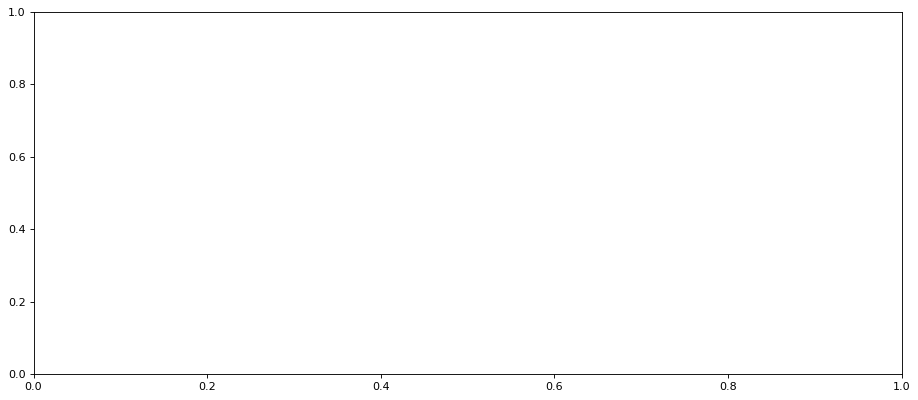

In [570]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['loss'], 'limegreen', label = 'Train', linewidth = 2)
ax.plot(history['val_loss'], '', label = 'Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize = 16)
ax.set_ylabel('Loss (MSE)')
ax.set_xlabel('Epotch')
ax.legend(loc = 'upper right')
plt.show()

In [596]:

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

predictions3 = model.predict(xValidScaled)
predictions = predictions3.reshape(predictions3.shape[0], predictions3.shape[2])
x_Valid_ = xValidScaled.reshape(xValidScaled.shape[0], xValidScaled.shape[2])
mse = np.mean(np.power(x_Valid_ - predictions, 2), axis = 1)

errorDf = pd.DataFrame({'reconstruction_error': mse, 'Target': yValid})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(errorDf['Target'], errorDf['reconstruction_error'])


#

best_d = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_d)]

print('precision:', precision_rt[np.argmin(best_d)])
print('threshold:', threshold_fixed)

precision: 0.10914085914085914
threshold: 6.935571730981221e-08


In [600]:
errorDf

,reconstruction_error,Target
0,4.066675e-08,0.0
1,7.066425e-08,0.0
2,1.588558e-06,1.0
3,8.580828e-08,0.0
4,1.335318e-08,0.0
...,...,...
75164,2.002741e-07,0.0
75165,5.943883e-08,0.0
75166,1.806304e-08,0.0
75167,1.225557e-08,0.0


In [624]:
OK_trainScaled.shape

(460693, 1, 4)

In [620]:
print(input_dim)

4


In [626]:
z = OK_trainS.shape[1]
print(z)

4


In [633]:
input_dim = OK_trainS.shape[1]
encoding_dim = 140

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
# 

In [634]:
# 00 에폭(epoch) 동안 16의 배치 사이즈(batch size
nb_epoch = 20
batch_size = 16
autoencoder.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model_LSTM.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)



2022-11-02 03:15:59.045406: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-02 03:15:59.045427: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-02 03:15:59.045755: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [635]:
history = autoencoder.fit(np.array(OK_trainS), np.array(OK_trainS), epochs=nb_epoch, batch_size=batch_size,
                    shuffle=True, validation_data=(xTest, xTest), verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history # MinMax scale // error -> list type floating


Epoch 1/20
  155/28794 [..............................] - ETA: 37s - loss: 0.0657 - accuracy: 0.5024

2022-11-02 03:16:01.035936: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-02 03:16:01.035955: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-02 03:16:01.052438: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-02 03:16:01.053233: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-02 03:16:01.054205: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_11_02_03_16_01

2022-11-02 03:16:01.055180: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_11_02_03_16_01/waniui-MacBook-Pro.local.trace.json.gz
2022-11-02 03:16:01.056334: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_11_02_03_16_01

2022-11-02 

28794/28794 [==============================] - 27s 932us/step - loss: 0.0601 - accuracy: 0.7347 - val_loss: 0.0479 - val_accuracy: 0.7927
Epoch 2/20
28794/28794 [==============================] - 26s 910us/step - loss: 0.0600 - accuracy: 0.7408 - val_loss: 0.0479 - val_accuracy: 0.7926
Epoch 3/20
28794/28794 [==============================] - 26s 912us/step - loss: 0.0037 - accuracy: 0.9750 - val_loss: 9.4501e-06 - val_accuracy: 0.9970
Epoch 4/20
28794/28794 [==============================] - 27s 923us/step - loss: 1.2635e-05 - accuracy: 0.9927 - val_loss: 3.8950e-05 - val_accuracy: 0.9842
Epoch 5/20
28794/28794 [==============================] - 26s 903us/step - loss: 1.0933e-05 - accuracy: 0.9924 - val_loss: 6.5553e-06 - val_accuracy: 0.9941
Epoch 6/20
28794/28794 [==============================] - 26s 902us/step - loss: 9.5995e-06 - accuracy: 0.9921 - val_loss: 7.6529e-06 - val_accuracy: 0.9936
Epoch 7/20
28794/28794 [==============================] - 26s 902us/step - loss: 8.8847e-

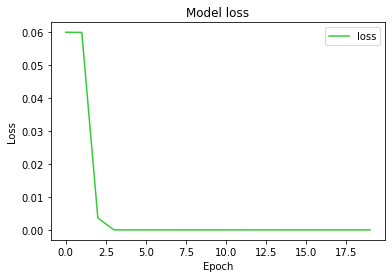

In [636]:
plt.plot(history['loss'], 'limegreen', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

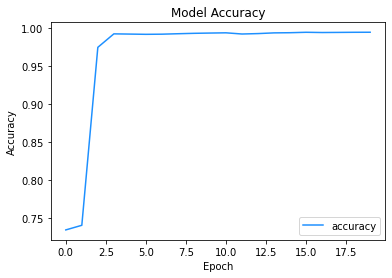

In [637]:
# 모델 정확도 시각화
plt.plot(history['accuracy'], 'dodgerblue', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [644]:
predictions = autoencoder.predict(xTest)
mse = np.mean(np.power(xTest - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'Target': yTest})
error_df

,reconstruction_error,Target
0,5.215507e-06,0.0
1,1.052742e-06,0.0
2,7.977637e-07,0.0
3,2.046636e-06,0.0
4,7.607391e-07,1.0
...,...,...
175387,1.528649e-06,0.0
175388,7.185647e-07,0.0
175389,5.093101e-06,0.0
175390,9.837076e-07,0.0


Text(0.5, 0, 'False Positive Rate')

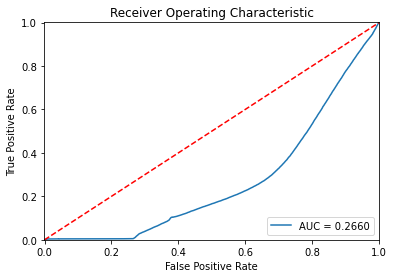

In [646]:
fpr, tpr, thresholds = roc_curve(error_df.Target, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [519]:
#np.where(yValid == 1.) # test_t[:,-2] #test_t[:, :-2].shape


(array([    2,     8,    16, ..., 75155, 75157, 75159]),)

In [608]:
xTestScaled.shape


(175392, 1, 4)

In [436]:
# dissoul_x_train, dissoul_x_test, dissoul_y_train, dissoul_y_test = train_test_split(dx, dy, train_size=0.7, test_size=0.3, random_state=42)

(177067, 7)

In [410]:
train_x_tensor = Variable(torch.Tensor(x_train.values))
train_y_tensor = Variable(torch.Tensor(y_train.values))


In [315]:
y_train.values.shape


(584640, 1)

In [319]:
y_test.values.shape


(250560,)

In [338]:
y_test = pd.DataFrame(y_test)


In [340]:
test_x_tensor = Variable(torch.Tensor(x_test))
test_y_tensor = Variable(torch.Tensor(y_test.values))


In [413]:
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))
test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))
test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]))



In [414]:
print(train_x_tensor_final.shape, test_x_tensor_final.shape) #3차원 데이터로 변환


torch.Size([584640, 1, 4]) torch.Size([250560, 1, 4])


In [411]:

# 정상 데이터 - train / test
# 이상 데이터 - 정상데이터를 맞추기위해 test_y로 함 
# print(a)



,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
284331,0.194656,0.050443,0.000869,0.333333
759167,0.370229,0.091463,0.004923,0.500000
383871,0.284351,0.000000,0.007819,0.166667
593721,0.265267,0.000000,0.003927,0.333333
163438,0.251908,0.031596,0.011963,0.166667
...,...,...,...,...
763412,0.253817,0.092572,0.008959,0.333333
366119,0.416031,0.087029,0.011981,0.333333
582486,0.166031,0.113082,0.002914,0.166667
49628,0.192748,0.036585,0.003891,0.333333


In [356]:
dis #dis


,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,0.345420,0.064302,0.011420,0.333333,0
1,2020-03-04 0:00,1,0.238550,0.043237,0.011022,0.333333,0
2,2020-03-04 0:00,2,0.297710,0.085366,0.011004,0.333333,0
3,2020-03-04 0:00,3,0.135496,0.117517,0.010968,0.333333,0
4,2020-03-04 0:00,4,0.935115,0.962306,0.010932,0.666667,0
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,0.853053,0.966186,0.005755,0.666667,0
835196,2020-04-30 23:59,835196,0.146947,0.114191,0.005737,0.333333,0
835197,2020-04-30 23:59,835197,0.299618,0.082040,0.005719,0.500000,0
835198,2020-04-30 23:59,835198,0.303435,0.000000,0.005683,0.333333,0


In [357]:
x = dis.iloc[:,0:-1]
y = dis.iloc[:,-1:]

In [364]:
x = x.drop(['STD_DT'], axis = 1)
x = x.drop(['NUM'], axis = 1)


In [365]:
class LSTM_Jun(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 

        super(LSTM_Jun, self).__init__()

        self.num_classes = num_classes

        self.num_layers = num_layers

        self.input_size = input_size

        self.hidden_size = hidden_size

        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

        self.layer_1 = nn.Linear(hidden_size, 256)

        self.layer_2 = nn.Linear(256,256)

        self.layer_3 = nn.Linear(256,128)

        self.layer_out = nn.Linear(128, num_classes)

        self.relu = nn.ReLU() #Activation Func

 

    def forward(self,x):

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State

        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States

 

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

 

        hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network

        out = self.relu(hn) #pre-processing for first layer

        out = self.layer_1(out) # first layer

        out = self.relu(out) # activation func relu

        out = self.layer_2(out)

        out = self.relu(out)

        out = self.layer_3(out)

        out = self.relu(out)

        out = self.layer_out(out) #Output layer

        return out

In [366]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [367]:
num_epochs = 20

learning_rate = 0.001

input_size = int(len(x.columns))

hidden_size = 2 # number of features in hidden state

num_layers = 1

num_classes = int(len(y.columns))

 

LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1]).to(device)

 

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(LSTM_Jun.parameters(), lr = learning_rate)

 

for epoch in range(num_epochs) : 

    outputs = LSTM_Jun.forward(train_x_tensor_final.to(device))

    optimizer.zero_grad()

    loss = loss_function(outputs, train_y_tensor.to(device))

    loss.backward()

    optimizer.step() # improve from loss = back propagation

    if epoch % 200 == 0 :

        print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))

 

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([584640, 1])) that is different to the input size (torch.Size([460561, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (460561) must match the size of tensor b (584640) at non-singleton dimension 0

In [78]:
dissoul_y

,TAG
0,0
1,0
2,0
3,0
4,0
...,...
835195,0
835196,0
835197,0
835198,0


In [69]:
#EDA에서 데이터가 골고루지 못함 -> 이상을 제거하게 되면 특징적으로 데이터 모두 INSP 한쪽으로 쏠리는 현상이 이루어짐 (학습 효과의 개선이 없음) 
# 표준화에서도 문제가 될 가능성이 제기됨.

from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 
x = dissoul_x.values # 독립변인들의 value값만 추출
y = dissoul_y.values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

#pd.DataFrame(x, columns=features).head()

In [70]:
x

array([[-0.15747603, -0.53763449,  0.0394528 , -0.41047981],
       [-0.59402979, -0.59706186,  0.02138452, -0.41047981],
       [-0.3523661 , -0.47820712,  0.02056324, -0.41047981],
       ...,
       [-0.3445705 , -0.48759039, -0.21925206,  0.43540881],
       [-0.3289793 , -0.71904435, -0.22089463, -0.41047981],
       [-0.43811774, -0.52355959, -0.22253721,  0.43540881]])

In [72]:
features = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']
pd.DataFrame(x, columns=features)

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
0,-0.157476,-0.537634,0.039453,-0.410480
1,-0.594030,-0.597062,0.021385,-0.410480
2,-0.352366,-0.478207,0.020563,-0.410480
3,-1.014992,-0.387502,0.018921,-0.410480
4,2.251365,1.995848,0.017278,1.281297
...,...,...,...,...
835195,1.916154,2.006795,-0.217609,1.281297
835196,-0.968219,-0.396885,-0.218431,-0.410480
835197,-0.344571,-0.487590,-0.219252,0.435409
835198,-0.328979,-0.719044,-0.220895,-0.410480


In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성

